In [1]:
from os import path 

import anndata
import openTSNE
import scanpy as sc
import numpy as np
import pandas as pd

import utils

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "h5ad", "tasic_2018.h5ad"))
adata

AnnData object with n_obs × n_vars = 23178 × 45768
    obs: 'cell_class', 'batch'
    uns: 'name', 'organism', 'tissue', 'year'

In [3]:
adata.obs.head()

,cell_class,batch
F2S4_150422_002_A01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_B01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_C01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_D01,Glutamatergic,Primary Visual Cortex (VISp)
F2S4_150422_002_E01,Glutamatergic,Primary Visual Cortex (VISp)


In [4]:
adata.obs["labels"] = adata.obs["cell_class"]

### Load colors from manuscript

In [5]:
metadata = pd.read_csv(path.join("..", "data", "tasic_2018", "tasic-sample_heatmap_plot_data.csv"), index_col=0)
metadata.head()

,cluster_id,cluster_color,cluster_label,class_id,class_color,class_label,Gad2_log10_cpm,Slc17a7_log10_cpm,Lamp5_log10_cpm,Sncg_log10_cpm,Vip_log10_cpm,Sst_log10_cpm,Pvalb_log10_cpm
sample_name,,,,,,,,,,,,,
F1S4_161216_001_A01,94,#53D385,L5 PT ALM Slco2a1,2,#27AAE1,Glutamatergic,0.000000,2.703004,2.644231,0.000000,0.194593,0.0,0.000000
F1S4_180124_314_A01,73,#33A9CE,L5 IT ALM Npw,2,#27AAE1,Glutamatergic,0.000000,2.655333,3.254294,0.000000,0.000000,0.0,0.000000
F1S4_180124_315_A01,2,#FF88AD,Lamp5 Fam19a1 Pax6,1,#EF4136,GABAergic,2.981714,0.000000,0.000000,0.968798,0.000000,0.0,0.000000
F1S4_180124_315_B01,8,#9440F3,Sncg Slc17a8,1,#EF4136,GABAergic,2.479560,0.000000,0.000000,2.388210,0.000000,0.0,1.685995
F1S4_180124_315_C01,8,#9440F3,Sncg Slc17a8,1,#EF4136,GABAergic,2.881715,0.000000,0.000000,3.005049,0.000000,0.0,0.952222


In [6]:
adata_mask = adata.obs_names.isin(metadata.index)
adata = adata[adata_mask]
adata

View of AnnData object with n_obs × n_vars = 21874 × 45768
    obs: 'cell_class', 'batch', 'labels'
    uns: 'name', 'organism', 'tissue', 'year'

In [7]:
adata.obs["cluster_color"] = metadata.loc[adata.obs_names.values, "cluster_color"]

Trying to set attribute `.obs` of view, copying.


## Preprocessing

In [8]:
sc.pp.filter_genes(adata, min_counts=10)
adata

AnnData object with n_obs × n_vars = 21874 × 40300
    obs: 'cell_class', 'batch', 'labels', 'cluster_color'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 4.74
CPU times: user 9.75 s, sys: 9.51 s, total: 19.3 s
Wall time: 17.1 s


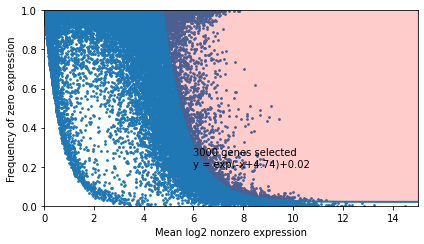

In [9]:
%time gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [10]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False)

In [11]:
adata.obsm["X_pca"] = utils.pca(adata.X[:, gene_mask])

## t-SNE Embeddings

In [12]:
init = openTSNE.initialization.rescale(adata.obsm["X_pca"][:, :2])

### Standard t-SNE

In [13]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization=init,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 4.20 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.62 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 5.1250, 50 iterations in 1.1201 sec
Iteration  100, KL divergence 4.2902, 50 iterations in 1.0864 sec
Iteration  150, KL divergence 4.0193, 50 iterations in 1.13

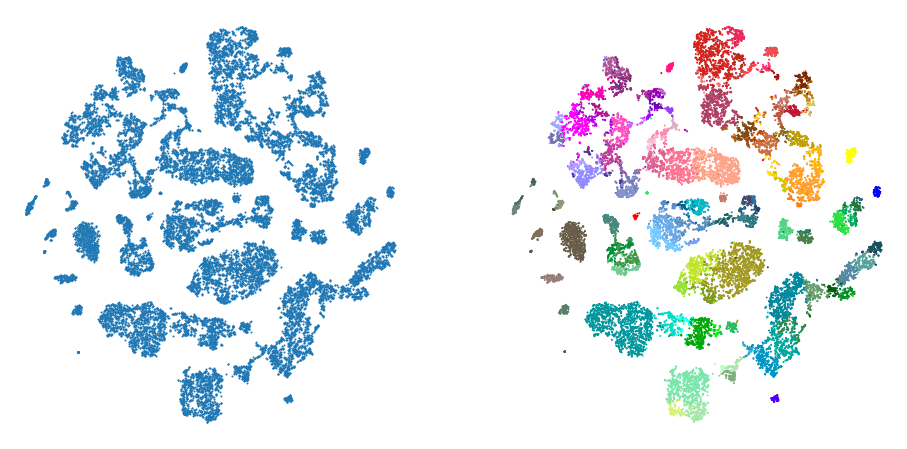

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_standard[:, 0], embedding_standard[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_standard[:, 0], embedding_standard[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### perplexity=500

In [15]:
embedding_perp500 = openTSNE.TSNE(
    perplexity=500,
    initialization=init,
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, perplexity=500, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 20.20 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 9.37 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 2.6219, 50 iterations in 6.0536 sec
Iteration  100, KL divergence 2.0701, 50 iterations in 6.0898 sec
Iteration  150, KL divergence 1.9559, 50

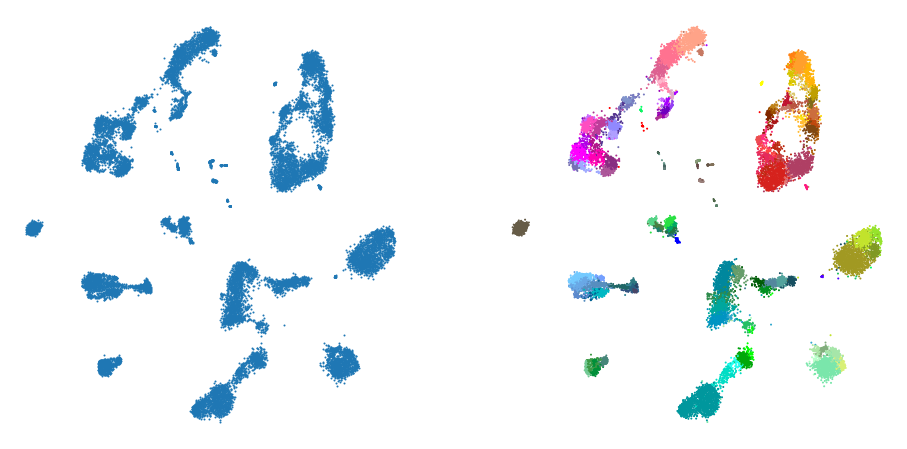

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_perp500[:, 0], embedding_perp500[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_perp500[:, 0], embedding_perp500[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### multiscale=30,500

In [19]:
%%time
affinities = openTSNE.affinity.Multiscale(
    adata.obsm["X_pca"],
    perplexities=[30, 500],
    metric="cosine",
    n_jobs=8,
    random_state=0,
    verbose=True,
)
embedding_ms = openTSNE.TSNE(
    initialization=init,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"], affinities=affinities)

===> Finding 1500 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 20.31 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 20.03 seconds
--------------------------------------------------------------------------------
TSNE(initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 3.5873, 50 iterations in 5.3932 sec
Iteration  100, KL divergence 2.9381, 50 iterations in 5.2692 sec
Iteration  150, KL divergence 2.7772, 50 iterations in 5.2366 sec
Iterat

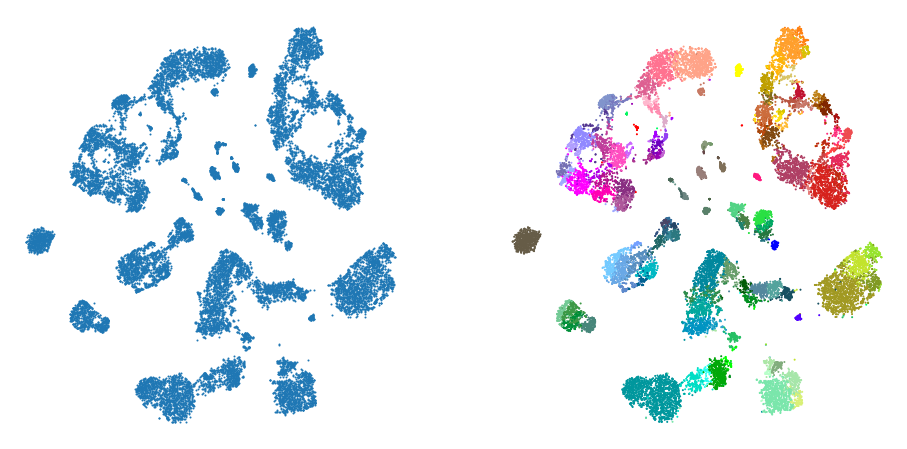

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_ms[:, 0], embedding_ms[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_ms[:, 0], embedding_ms[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

### dof=0.6

In [21]:
embedding_dof06 = openTSNE.TSNE(
    perplexity=30,
    initialization=init,
    metric="cosine",
    dof=0.6,
    n_jobs=8,
    random_state=0,
    verbose=True,
).fit(adata.obsm["X_pca"])

--------------------------------------------------------------------------------
TSNE(dof=0.6,
     initialization=array([[ 4.76676505e-04,  1.01634636e-04],
       [ 4.52835520e-04, -9.44409403e-05],
       [ 5.27897791e-04, -8.27442927e-05],
       ...,
       [ 4.98961541e-04,  9.29581147e-05],
       [ 5.22054615e-04,  1.06791849e-04],
       [ 5.02711046e-04,  9.66855951e-05]], dtype=float32),
     metric='cosine', n_jobs=8, random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using cosine distance...
   --> Time elapsed: 5.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.51 seconds
===> Running optimization with exaggeration=12.00, lr=1822.83 for 250 iterations...
Iteration   50, KL divergence 5.4907, 50 iterations in 1.3091 sec
Iteration  100, KL divergence 4.8873, 50 iterations in 1.2728 sec
Iteration  150, KL divergence 4.6648, 50 iter

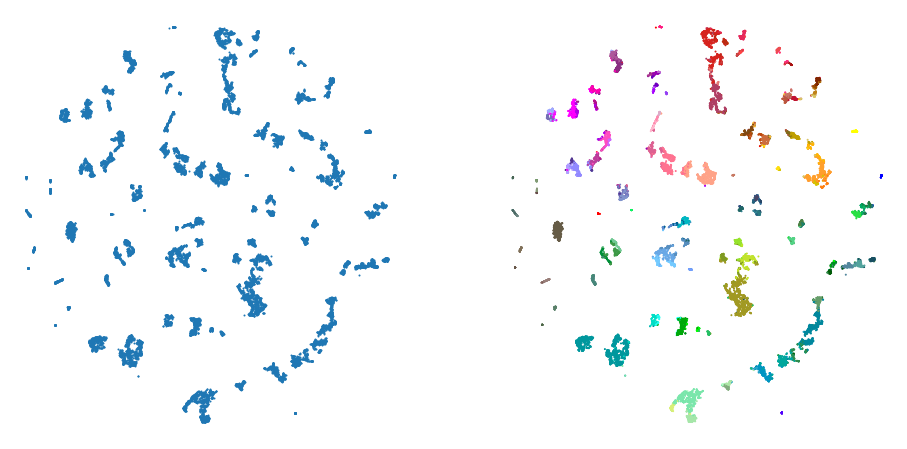

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(embedding_dof06[:, 0], embedding_dof06[:, 1], s=1, alpha=1, c="tab:blue")
ax[1].scatter(embedding_dof06[:, 0], embedding_dof06[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"])
for ax_ in ax.ravel():
    ax_.axis("off")

## Final figure

In [23]:
pd.DataFrame(embedding_standard, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/standard.csv")
pd.DataFrame(embedding_perp500, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/perp500.csv")
pd.DataFrame(embedding_ms, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/multiscale.csv")
pd.DataFrame(embedding_dof06, columns=["tSNE-1", "tSNE-2"], index=adata.obs_names).to_csv("tasic/dof06.csv")

In [24]:
embedding_standard = pd.read_csv("tasic/standard.csv", index_col=0).values
embedding_perp500 = pd.read_csv("tasic/perp500.csv", index_col=0).values
embedding_ms = pd.read_csv("tasic/multiscale.csv", index_col=0).values
embedding_dof06 = pd.read_csv("tasic/dof06.csv", index_col=0).values

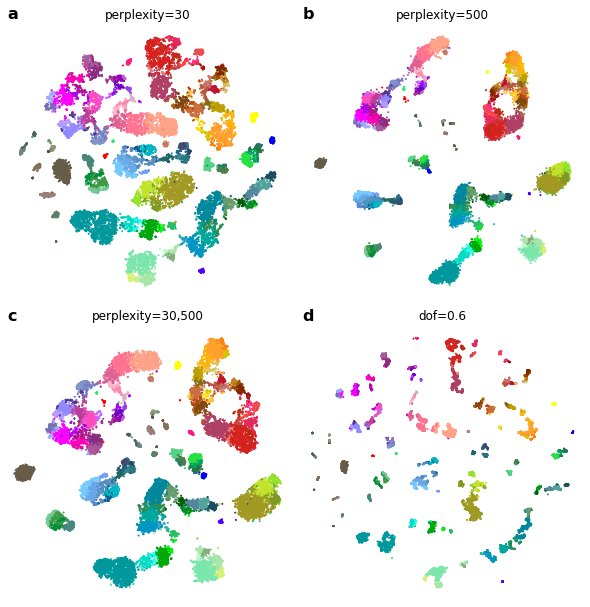

In [25]:
import string

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

for ax_, (title, emb) in zip(ax.ravel(), [
    ["perplexity=30", embedding_standard],
    ["perplexity=500", embedding_perp500],
    ["perplexity=30,500", embedding_ms],
    ["dof=0.6", embedding_dof06],
]):
    ax_.scatter(emb[:, 0], emb[:, 1], s=1, alpha=1, c=adata.obs["cluster_color"], rasterized=True)
    ax_.set_title(title)

for ax_ in ax.ravel():
    ax_.axis("off")
    ax_.axis("equal")

for ax_, letter in zip(ax.ravel(), string.ascii_lowercase): 
    plt.text(0, 1.02, letter, transform=ax_.transAxes, fontsize=16, va="baseline", fontweight="bold")
    
fig.subplots_adjust(wspace=0.05, hspace=0.1, top=1, bottom=0, left=0, right=1)

#plt.savefig(path.join("..", "figures", "tasic2018.pdf"), dpi=300, bbox_inches="tight", transparent=True, width=8, height=8)
plt.savefig(path.join("..", "figures", "tasic2018.pdf"), dpi=72, bbox_inches="tight", transparent=True, width=1200/72, height=1200/72)
#plt.savefig(path.join("..", "figures", "tasic2018.tiff"), dpi=180, bbox_inches="tight", transparent=True, width=8, height=8)